# ClipMorph: neural style transfer for videos with consistency 

This notebook contains early code for training a ClipMorph model. 
Authors: Lewin Sacha, Louette Arthur, Schyns Axelle, and Boveroux Laurie.

In [6]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.models as models
from torchvision import transforms as T
from torch.optim import Adam
from tqdm import tqdm

from PIL import Image

import random
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## VGG19 and Fast Style Net models

In [7]:
'''
VGG19 serves as a pretrained model to extract high-level representations of images.

It is always frozen during training of the other network that stylizes images.
'''
class Vgg19(nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        vgg_features = models.vgg19(pretrained=True).features
        self.block1 = nn.Sequential()
        self.block2 = nn.Sequential()
        self.block3 = nn.Sequential()
        self.block4 = nn.Sequential()
        for i in range(4):
            self.block1.add_module(str(i), vgg_features[i])
        for i in range(4, 9):
            self.block2.add_module(str(i), vgg_features[i])
        for i in range(9, 16):
            self.block3.add_module(str(i), vgg_features[i])
        for i in range(16, 23):
            self.block4.add_module(str(i), vgg_features[i])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, X):
        # Return outputs of ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
        vgg_outputs = []
        y = self.block1(X)
        vgg_outputs.append(y)
        y = self.block2(y)
        vgg_outputs.append(y)
        y = self.block3(y)
        vgg_outputs.append(y)
        y = self.block4(y)
        vgg_outputs.append(y)
        return vgg_outputs

In [8]:
"""
Outputs a stylized image from a given image.

One model is trained per image.
"""
class FastStyleNet(nn.Module):
    def __init__(self):
        super(FastStyleNet, self).__init__()

        # Convolution block
        self.convBlock = nn.Sequential(
            ConvoLayer(3, 32, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm2d(32, affine=True), 
            nn.ReLU(),                          
            ConvoLayer(32, 64, kernel_size=3, stride=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
            ConvoLayer(64, 128, kernel_size=3, stride=2),
            nn.InstanceNorm2d(128, affine=True),  
            nn.ReLU()
        )

        # Residual block
        self.residualBlock = nn.Sequential(
            ResidualLayer(128),
            ResidualLayer(128),
            ResidualLayer(128),
            ResidualLayer(128),
            ResidualLayer(128)
        )

        # Deconvolution block
        self.convTransBlock = nn.Sequential(
            ConvTrans(128, 64, kernel_size=3, stride=2, output_padding=1),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
            ConvTrans(64, 32, kernel_size=3, stride=2, output_padding=1),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
            ConvoLayer(32, 3, kernel_size=9, stride=1, padding=4),
        )
        
    def forward(self, X):
        y = self.convBlock(X)
        y = self.residualBlock(y)
        y = self.convTransBlock(y)
        return y
        
class ConvoLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1):
        super(ConvoLayer, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.reflection_pad = nn.ReflectionPad2d(padding)

    def forward(self, x):
        y = self.reflection_pad(x)
        y = self.conv2d(y)
        return y

class ResidualLayer(nn.Module):
    def __init__(self, channels):
        super(ResidualLayer, self).__init__()
        self.conv1 = ConvoLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvoLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        y = self.relu(self.in1(self.conv1(x)))
        y = self.in2(self.conv2(y))
        y = y + residual
        return y

class ConvTrans(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, output_padding=1):
        super(ConvTrans, self).__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

    def forward(self, x):
        return self.convTrans(x)

## Dataset class and data loader functions

In [9]:
class Data(data.Dataset):
    def __init__(self, root_dir, img_size):
        super().__init__()
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.img_size = img_size
        
    def __len__(self):
        return len(self.img_names) 
        
    def __getitem__(self, ind):    
        img_name = self.img_names[ind]
        img_path = self.root_dir + "/" + img_name
        img = Image.open(img_path, mode='r')

        # Resize image and rescale pixel values from [0,1] to [0,255].
        transform = T.Compose([
            T.Resize(self.img_size),
            T.CenterCrop(self.img_size),
            T.ToTensor(),
            T.Lambda(lambda x: x.mul(255))
        ])                                          

        # Expand 1-channel images to 3 channels.
        img = transform(img)
        if img.size()[0] != 3:
            img = img.expand(3, -1, -1)        
        return img
        
def load_data(root_dir, img_size, batch_size):
    data_train = Data(root_dir, img_size)
    
    train_data_loader = data.DataLoader(
        data_train, 
        batch_size=batch_size,  
        shuffle=True, 
        pin_memory=True
    )   
    
    return train_data_loader

def load_image(filename, size=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size))
    return img

### Normalize style image due to VGG19 image net

In [10]:
def norm_batch_vgg(batch):
    #Normalization due to how VGG19 networks were trained
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0) # because previously multiplied by 255.
    return (batch - mean) / std

### Style Loss along with Gram matrix and Total Variation Loss

In [11]:
def gram_matrix(y):
    """
    Computes the Gram matrix

    Arguments:
        y: Pytorch tensor of shape (batch size, channels, height, width).
    """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram

def style_loss(gram_style_img, curr_img_features, criterion, n_batch):
    """
    Sum MSE's from the chosen output layers of VGG

    Arguments:
        gram_style_img: Gram matrix of the style representation of the style image
        curr_img_features: Output of the VGG network for the current image
        criterion: Loss criterion
        n_batch: Number of images in the batch
    """

    L_style = 0
    for curr_feat, gram_style in zip(curr_img_features, gram_style_img):
        curr_gram = gram_matrix(curr_feat)
        L_style += criterion(curr_gram, gram_style[:n_batch, :, :])
    return L_style

def tot_variation_loss(img):
    """
    Computes the total variation loss.

    From: https://en.wikipedia.org/wiki/Total_variation_denoising
    """

    loss = (torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) 
        + torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :])))
    return loss

## Train the Fast Style Net (VGG19 is fixed)

In [12]:
def train(train_img_dir, img_train_size, style_img_name, batch_size, nb_epochs, 
    content_weight, style_weight, tv_weight, temporal_weight, noise_count, noise, name_model):
    """
    Train a fast style network to generate an image with the style of the style image.

    Arguments:
        train_img_dir: Directory where the training images are stored (Genome)
        img_train_size: Size of the training images
        style_img_name: Name of the style image
        batch_size: Number of images per batch
        nb_epochs: Number of epochs
        content_weight: Weight of the content loss
        style_weight: Weight of the style loss
        tv_weight: Weight of the total variation loss
        temporal_weight: Weight of the temporal loss
        noise_count: Number of pixels to add noise to
        noise: Noise range
        name_model: Name of the model

    Returns:
        The trained model.
    """
    
    data_loader = load_data(train_img_dir, img_train_size, batch_size)

    fsn = FastStyleNet().to(device)
    optimizer = Adam(fsn.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    vgg = Vgg19().to(device)

    transfo_style = T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x.mul(255))
        ])
    style_img = load_image("./style/"+style_img_name)
    style_img = transfo_style(style_img)
    style_img = style_img.repeat(batch_size,1,1,1).to(device)
    style_img = norm_batch_vgg(style_img)

    # Get style feature representation
    feat_style = vgg(style_img)
    gram_style = [gram_matrix(i) for i in feat_style] 

    tot_loss=[]; styl_loss=[]; content_loss=[]; temp_loss=[]; tv_loss=[]
    for e in range(nb_epochs):
        fsn.train()
        count = 0


        noise_img_a = np.zeros((3, img_train_size, img_train_size), dtype=np.float32)
        for _ in range(noise_count):
            x = random.randrange(img_train_size)
            y = random.randrange(img_train_size)
            noise_img_a[0][x][y] += random.randrange(-noise, noise)
            noise_img_a[1][x][y] += random.randrange(-noise, noise)
            noise_img_a[2][x][y] += random.randrange(-noise, noise)
            noise_img = torch.from_numpy(noise_img_a)
            noise_img = noise_img.to(device)

        
        for x in tqdm(data_loader):
            n_batch = len(x)
            count += n_batch
            x = x.to(device)
            optimizer.zero_grad()

            y_noisy = fsn(x+noise_img)
            y_noisy = norm_batch_vgg(y_noisy)
            
            y = fsn(x)
            x = norm_batch_vgg(x)
            y = norm_batch_vgg(y)
            x_feat = vgg(x)
            y_feat = vgg(y)

            # We take the output of layer "relu3_3" -> 2nd output of the list
            L_content = content_weight * criterion(x_feat[2], y_feat[2])
            L_style = style_weight * style_loss(gram_style, y_feat, criterion, n_batch)
            L_tv = tv_weight * tot_variation_loss(y)

            # Small changes in the input should result in small changes in the output.
            L_temporal = temporal_weight * criterion(y, y_noisy)
            L_total = L_content + L_style #+ L_tv + L_temporal
            tot_loss.append(L_total.item()); content_loss.append(L_content.item()); styl_loss.append(L_style.item())
            temp_loss.append(L_temporal.item()); tv_loss.append(L_tv.item())

            #if False:
            #    print('Epoch {}, L_total: {}, L_content {}, L_style {}, L_tot_var {}, L_temporal {}'
            #                    .format(e, L_total.data, L_content.data, L_style.data, L_tv.data, L_temporal.data))

            L_total.backward()
            optimizer.step()
            x.to('cpu')
        noise_img.to('cpu') # release GPU memory

    # Save model
    fsn.eval().cpu()
    save_model = name_model + ".pth"
    path_model = "./models/" + save_model
    torch.save(fsn.state_dict(), path_model)

    # lease the GPU memory
    vgg.to('cpu')
    fsn.to('cpu')
    style_img.to('cpu')

    return tot_loss, content_loss, styl_loss, temp_loss, tv_loss

## Main for training
One model must be trained per style image. 
To train, you need:
- a dataset folder of photograph images, put the path to it in the 'train_img_dir' below.
- a 'style' folder where you put your styles images. Then you enter the style image name in 'style_img_name' below.
- a 'models' folder where your trained model will be saved as "style_img_name.pth".

100%|██████████| 32173/32173 [1:29:22<00:00,  6.00it/s]


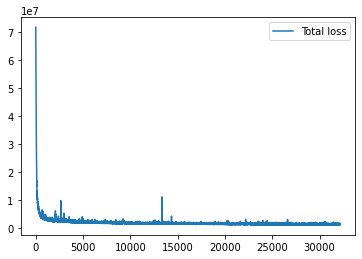

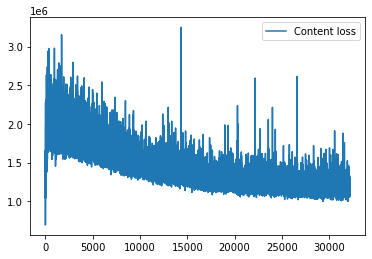

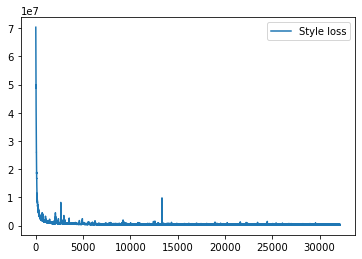

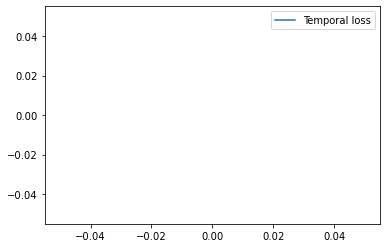

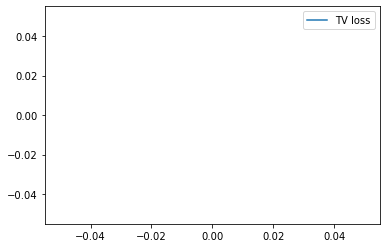

<Figure size 432x288 with 0 Axes>

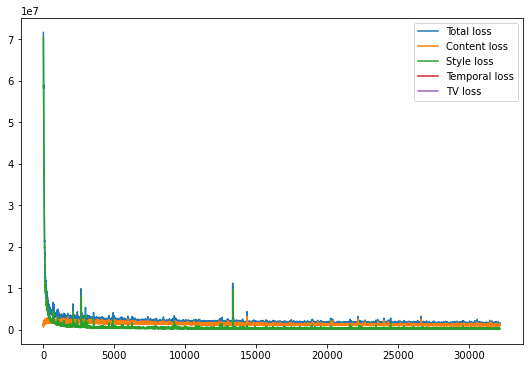

In [48]:
# Visual Genome dataset link : https://cs.stanford.edu/people/rak248/VG_100K_2/images.zip
train_img_dir = "./VG_100K"
style_img_name = "vangogh.jpg"
img_train_size = 512    
batch_size = 2
nb_epochs = 1
content_weight = 1e5    # Content loss weighting factor
style_weight = 4e10     # Style loss weighting factor
tv_weight = 1e-6        # Total variation loss weighting factor
temporal_weight = 1300  # Temporal loss weighting factor
noise_count = 1000      # number of pixels to modify with noise
noise = 30              # range of noise to add
name_model = os.path.splitext(style_img_name)[0] # name of the model that will be saved after training
tot_loss, content_loss, styl_loss, temp_loss, tv_loss = train(
    train_img_dir, img_train_size, style_img_name, batch_size, nb_epochs, 
    content_weight, style_weight, tv_weight, temporal_weight, noise_count, noise, name_model)

# Plot losses
if True:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(tot_loss, label='Total loss'); plt.legend()
    plt.figure()
    plt.plot(content_loss, label='Content loss'); plt.legend()
    plt.figure()
    plt.plot(styl_loss, label='Style loss');  plt.legend()
    plt.figure()
    plt.plot(temp_loss, label='Temporal loss'); plt.legend()
    plt.figure()
    plt.plot(tv_loss, label='TV loss'); plt.legend()
    plt.figure()
    plt.figure(figsize=(9,6))
    plt.plot(tot_loss, label='Total loss'); plt.plot(content_loss, label='Content loss')
    plt.plot(styl_loss, label='Style loss'); plt.plot(temp_loss, label='Temporal loss')
    plt.plot(tv_loss, label='TV loss')
    plt.legend()
    plt.show()

# Stylization with trained Fast Style Net

In [2]:
def neural_style_transfer(model_path, content_dir, output_dir):
    """
    Apply a model to all images in a directory and save the result in another directory.

    Args:
        model_path: path to the model
        content_dir: path to the directory containing the content images
        output_dir: path to the directory where the output images will be saved
    """

    style_model = FastStyleNet()
    style_model.load_state_dict(torch.load(model_path))
    style_model.to(device)

    img_list = os.listdir(content_dir)

    for i in tqdm(range(len(img_list))):
        img_path = content_dir + str(i) + ".jpg"
        content_image = load_image(img_path)
        content_trans = T.Compose([
            T.ToTensor(),
            T.Lambda(lambda x: x.mul(255))
        ])
        content_img = content_trans(content_image)

        if content_img.size()[0] != 3:
            content_img = content_img.expand(3, -1, -1)
        content_img = content_img.unsqueeze(0).to(device)

        with torch.no_grad():
            stylized = style_model(content_img).cpu()
        stylized = stylized[0]
        stylized = stylized.clone().clamp(0, 255).numpy()
        stylized = stylized.transpose(1, 2, 0).astype("uint8")
        stylized = Image.fromarray(stylized)
        stylized.save(output_dir + str(i) + ".jpg")

### Utils for stylization

In [4]:
import cv2
import time
import os
import numpy as np

def video_to_frames(input_loc, output_loc):
    """
    Extract frames from input video file
    and save them as separate frames in an output directory.

    Reference: https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
    
    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.

    Returns:
        fps : frame rate of the source video
    """
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        if not ret:
            continue
        # Write the results back to output location.
        cv2.imwrite(output_loc + str(count) + ".jpg", frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break
    return fps

def frames_to_video(input_loc, output_loc, fps):
    img_array = []
    img_list = os.listdir(input_loc)
    for i in range(len(img_list)):
        path = input_loc + str(i) + ".jpg"
        img = cv2.imread(path)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(output_loc,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

## Main for stylization :
Once you have a model trained on a style image, you can stylize any content image in near real-time.  
To stylize an image or GIF or video, you need : 
- an image (jpg) or a GIF or a video (mp4)
- a 'models' folder containing the trained model for a style image
- a 'frames_video" folder (can be empty or not)
- a 'frames_video_stylized' foler (can be empty or not)

In [14]:
path_to_original = "./content/car.gif"  # Path to the file you want stylize. Can have extensions '.jpg', '.gif', '.mp4'
model_dir = "./models/vangogh.pth"   # Path to the model you use to stylize your file
content_dir = "./frames_video/"         # Path to which the original video frames will be extract. (If image, does not matter)
output_dir = "./frames_video_stylized/" # Path to which the stylized video frames will be put
stylized_dir = "./result/"      # Path to the final stylized file

# First delete all files in the content_dir
import os 
for f in os.listdir(content_dir):
    os.remove(content_dir+f)

# Extract frames if gif or video
name, ext = os.path.splitext(os.path.basename(path_to_original))

if ext == '.jpg':
    style_model = FastStyleNet()
    style_model.load_state_dict(torch.load(model_dir))
    style_model.to(device)
    img_path = path_to_original
    content_image = load_image(img_path)
    content_trans = T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x.mul(255))
    ])
    content_img = content_trans(content_image)
    if content_img.size()[0] != 3:
        content_img = content_img.expand(3, -1, -1)
    content_img = content_img.unsqueeze(0).to(device)
    with torch.no_grad():
        stylized = style_model(content_img).cpu()
    stylized = stylized[0]
    stylized = stylized.clone().clamp(0, 255).numpy()
    stylized = stylized.transpose(1, 2, 0).astype("uint8")
    stylized = Image.fromarray(stylized)
    stylized.save(stylized_dir + path_to_original.split('/')[-1])
    print('Image stylized.')
else:
    if ext == '.gif':
        from PIL import Image
        imageObject = Image.open(path_to_original)
        for frame in range(0,imageObject.n_frames):
            imageObject.seek(frame)
            imageObject.convert('RGB').save(content_dir+str(frame)+".jpg")
    elif ext == '.mp4':
        fps = video_to_frames(path_to_original, content_dir)

    # Delete all files in the output_dir and apply stylization
    for f in os.listdir(output_dir):
        os.remove(output_dir+f)
    neural_style_transfer(model_dir, content_dir, output_dir)

    # Reconstruct gif or video and put the new stylized file in 'stylized_dir'
    if ext == '.gif':
        frames = os.listdir(output_dir)
        GIF_list=[]
        for i in range(len(frames)):
            new_frame = Image.open(output_dir+str(i)+".jpg")
            GIF_list.append(new_frame)
        # Save into a GIF 
        GIF_list[0].save(stylized_dir+name+'.gif', format='GIF',
                    append_images=GIF_list[1:],
                    save_all=True,)
    elif ext == '.mp4':
        frames_to_video(output_dir, stylized_dir+name+'.mp4', fps)

Image stylized.
